# Vizualization - Receiver Operating Characteristic (ROC) curve

In this tutorial, we'll revisit the Iris dataset and understand the concept of ROC curves. These are very helpful in understanding the behavior of classifiers and how they balance true and false positives.

A receiver operating characteristic curve (ROC) curve illustrates the performance of a binary classifier system, in terms of true and false positives detected, as its threshold for classification is varied.

To create a ROC curve, plot the true positive rate (TPR) and false positive rate (FPR) as functions of a classifier parameter, such as discrimination threshold. The TPR defines how many correct positive results occur among all positive samples available during the test. FPR, on the other hand, defines how many incorrect positive results occur among all negative samples available during the test.

If the probability distributions for both recall and fall-out are known, the ROC curve can be generated by plotting the cumulative distribution function (area under the probability distribution):

![plot](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4f/ROC_curves.svg/709px-ROC_curves.svg.png "Probability Distribution, courtesy Wikipedia")

Source: Wikimedia

## Case Study

Before we get into the code, let's talk about why ROC curves are important. 

Let's use this old statistics textbook chestnut: suppose you have developed a diagnostic test that has **99.5% accuracy**. 

Wow! Great job! Now, the test is for a disease with a prevalence of **1 in 10,000**. 

You decide to run the test on all the residents of New York City, because the NIH's coffers are huge and you have unlimited funding (let's say we're on a different Earth, or an alterate timeline where R&D is valued). 

If you run the test on all residents of NYC, that's **8.5 million** people.

Since NYC has a population of 8.5M, we can estimate that **850 people should have the disease and you should positively identify about 846 of them** with a single test: 

(8.5M people)\*(1/10,000 disease/normal)\*(0.995) = 846 diseased people. 

As a warning, since your test is bit inaccurate, you should expect some false negatives (Type II error).

--- 

OK so let's look at the math and see how many patients we test as "positive." 


In [1]:
import numpy as np

def confusion_matrix(acc=0.995, subpop=1e-4, population=8.5e6):
    """
    Generates confusion matrix and derivations.

    acc: accuracy of detecting subpop
    subpop: % of population in subpopulation
    population: Total population size
    """

    # Inputs
    population = int(population)
    print(f"\nInputs\n------------")
    print(f"Accuracy (%): {100*acc}")
    print(f"Subpopulation (%): {100*subpop}")
    print(f"Population size: {population}")
    print(f"Predicted subpopulation size: {int(subpop*population)}")

    # Check variables
    if acc > 1 or acc < 0:
        print("\nERROR: give valid accuracy (0 --> 1).")
        return
    if subpop > 1 or subpop < 0:
        print("\nERROR: give valid subpop percent (0 --> 1).")
        return
    if population < 1:
        print("\nERROR: cannot have zero or negative populations.")
        return

    # confusion matrix
    tp = np.rint(population*subpop*acc).astype(int)
    fp = np.rint(population*(1-acc)).astype(int)
    tn = np.rint(population*(1-subpop)*acc).astype(int)
    fn = np.rint(population*subpop).astype(int) - tp
    print(f"\nResults\n------------")
    print(f"True Positives (Power): {tp}")
    print(f"False Positives (Type I): {fp}")
    print(f"True Negatives: {tn}")
    print(f"False Negatives (Type II): {fn}")

    # derivations
    round_var = 4
    tpr = np.round((tp)/(tp+fn), round_var)
    fpr = np.round((fp)/(fp+tn), round_var)
    precision = np.round((tp)/(tp+fp), round_var)
    specificity = np.round((tn)/(tn+fp), round_var)
    fdr = np.round((fp)/(fp+tp), round_var)
    fscore = np.round(2*tp/(2*tp+fp+fn), round_var)
    print(f"\nDerivations\n------------")
    print(f"True Positive Rate (Recall): {tpr}")
    print(f"False Positive Rate: {fpr}")
    print(f"Precision: {precision}")
    print(f"Specificity: {specificity}")
    print(f"False Discovery Rate: {fdr}")
    print(f"F-Score: {fscore}")

    # output_dict
    output = {
        'True_Positives':tp,
        'False_Positives':fp,
        'True_Negatives':tn,
        'False_Negatives':fn,
        'TPR':tpr,
        'FPR':fpr,
        'Precision':precision,
        'Specificity':specificity,
        'FDR':fdr,
        'FScore':fscore
    }

    return output


_ = confusion_matrix()


Inputs
------------
Accuracy (%): 99.5
Subpopulation (%): 0.01
Population size: 8500000
Predicted subpopulation size: 850

Results
------------
True Positives (Power): 846
False Positives (Type I): 42500
True Negatives: 8456654
False Negatives (Type II): 4

Derivations
------------
True Positive Rate (Recall): 0.9953
False Positive Rate: 0.005
Precision: 0.0195
Specificity: 0.995
False Discovery Rate: 0.9805
F-Score: 0.0383


Hold on a minute ... your results came back and you actually found **43,346** people with the disease!

What happened? Well, that 99.5% accuracy means there's 0.5% *inaccuracy*. And since your two classes (diseased vs. normal) are dramatically imbalanced, that means you are likely to accumulate a ton of false positives (Type I error).

Though the True Positive Rate and Specificity look good, the high Type I error led to very low Precision and high False Discovery Rate. Essentially, a lot of healthy people are going to think they're sick.

This case study is just to illustrate that **accuracy is not necessarily the best metric to use when deciding on a classifier**. Instead, it's better to understand the trade-off between precision and recall or your true and false positive rates.

Oh, one last thing. Run the test on your positives again (maybe two more times). Each time, you'll filter out your false positives, because their probability of testing positive multiple times is very low (praise be the Reverend Thomas Bayes).

### Load libraries

In [4]:
# Load packages
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split, StratifiedKFold  # sklearn > v0.18
from sklearn.linear_model import LogisticRegression
from itertools import cycle
import matplotlib.pyplot as plt
from matplotlib.colors import cnames
cnames = dict((k, v) for k, v in cnames.items() if 'dark' in k) # get only dark colors

%matplotlib inline

### Import data and run 2D PCA

In [5]:
# Load data
data = datasets.load_breast_cancer()
X = data.data
y = data.target
data_colors = list(data.target_names)

""" REPLACE IRIS WITH SYNTHETIC 2D DATA """
# Synthetic data with highly imbalance classes
from sklearn.datasets import make_classification
minority_class_prevalence = 0.1
class_balance = [minority_class_prevalence, 1.0-minority_class_prevalence]
X, y = make_classification(n_classes=2, 
                           n_features=2, 
                           n_samples=8500,
                           weights=class_balance, 
                           random_state=42)
X_t = StandardScaler().fit_transform(X)
rf_clf = RandomForestClassifier(random_state=2)
rf_clf = plot_binary_ROC(rf_clf, X_t, y, cv_fold=3)

/Users/gkaushik/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


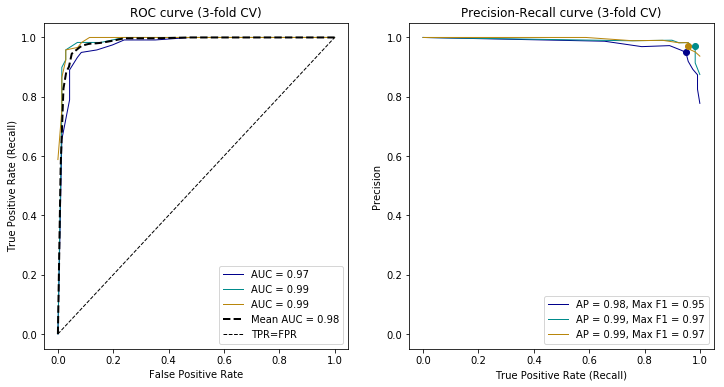

In [6]:
def plot_binary_ROC(clf, X, y, scaler=None, cv_fold=3, pos_label_=None, figsize_=(12,6), png_filename=None, verbose=False):
    """
    Plot a ROC curve for a binary classifier with n='cv-fold' cross-validations.
    
    clf:          untrained classifier object (e.g. rf_clf = RandomForestClassifer())
    X:            training + testing data
    y:            targets (numeric/integers)
    scaler:       scaler to rescale data, e.g. StandardScaler() [default: None]
    cv_fold:      cross-validations to run [default: 3]
    figsize_:     figsize for plot (x,y) [default: (12,6)] 
    pos_label_:   if targets are not binary (0, 1) then indicate integer for "positive" [default: None]
    png_filename: if you wish to save to png, give filename [default: None]
    verbose:      print warnings [default: False]
    """
    
    """ Setup """
    from sklearn.model_selection import train_test_split, StratifiedKFold  # sklearn > v0.18

    # rescale data
    if scaler is not None:
        X = scaler.fit_transform(X)
        if verbose:
            print(f"Data (X) rescaled using {scaler}.")

    # Set up mean true and false positive rates
    # -- mean_tpr begins as 0, and we'll update it as we fit the classifiers
    # -- mean_fpr is our x-axis so we pre-calculate it from 0 to 100 (%)
    mean_tpr, mean_fpr = 0, np.linspace(0, 1, 101) # np.linspace(start, stop, datapoints)
    mean_prec, mean_rec = 0, np.linspace(0, 1, 101) # np.linspace(start, stop, datapoints)

    # Set the cross-validation fold
    if cv_fold > 1:
        skf = StratifiedKFold(cv_fold)
    else:
        print(f"ERROR: cv_fold set as {cv_fold}, but must be > 1.")
        return clf

    """ Plotting """
    
    # Create new plot
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=figsize_)
    
    # Set the matplotlib colorwheel as a cycle
    colors = cycle(list(cnames.keys()))
    
    # Loop over each split in the data and plot the ROC for each cv_fold
    # -- skf.split(X,y) returns n=cv_fold splits of the data
    # -- zip(skf..., colors) will return a list of tuples with the split data (itself a tuple) and a color
    # -- each loop will therefore get its own split of the data and a color for plotting
    # -- idx, val in enumerate(...) returns the index (idx) of our loop (0, 1, 2... cv_fold-1)
    #        and the actual value i.e. the split data and color
    for idx, val in enumerate(zip(skf.split(X, y), colors)):
        
        # retrieve training and test data and color/labels
        (train, test), color = val

        # train and retrieve probabilities of class per feature for the test data
        # probas_ will have a shape of n_instances by 2 classes, with the sum of each row = 1
        try:
            probas_ = clf.fit(X[train], y[train]).predict_proba(X[test])
        except:
            print("Check if classifer allows for probability calculation.")
            break

        # get false and true positive rates (and thresholds, which is not used but shown here for fyi)
        try:
            fpr, tpr, _ = roc_curve(y[test], probas_[:,1], pos_label=pos_label_)
            precision, recall, _ = precision_recall_curve(y[test], probas_[:,1], pos_label=pos_label_)
            f1_score = 2*(precision*recall)/(precision+recall)
            avg_precision = average_precision_score(y[test], probas_[:,1])
        except:
            print(f"Warning: target data not binary. Maximum target value of '{np.max(y)}' used as positive.")
            print("You can use 'pos_label_' to indicate your own.")
            fpr, tpr, _ = roc_curve(y[test], probas_[:, 1], pos_label=np.max(y))
            precision, recall, _ = precision_recall_curve(y[test], probas_[:,1], pos_label=np.max(y))
            f1_score = 2*(precision*recall)/(precision+recall)
            avg_precision = average_precision_score(y[test], probas_[:,1])

        # get area under the curve
        roc_auc = auc(fpr, tpr)
        
        # recalculate mean_tpr curve w/ linear interpolation with mean_fpr, fpr, and tpr
        mean_tpr += np.interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0

        # recalculate mean_prec curve w/ linear interpolation
        mean_prec += np.interp(mean_fpr, recall, precision)
        
        # PLOT current ROC curve
        ax1.plot(fpr, tpr, lw=1, color=color, label=f'AUC = {roc_auc:.2f}')
        
        # PLOT precision-recall curve with max f1_score
        max_f1 = np.max(f1_score)
        max_f1_recall = recall[np.argmax(f1_score)]
        ax2.plot(recall, precision, lw=1, color=color, label=f'AP = {avg_precision:.2f}, Max F1 = {max_f1:.2f}')
        ax2.plot(max_f1_recall, max_f1, 'o', color=color, label=None)

    # ROC - PLOT avg roc of all curves
    mean_tpr /= skf.get_n_splits(X, y) # normalize by dividing by number of splits
    mean_tpr[-1] = 1.0 # constrain last index to 1
    mean_auc = auc(mean_fpr, mean_tpr)
    ax1.plot(mean_fpr, mean_tpr, color='k', linestyle='--', label=f'Mean AUC = {mean_auc:.2f}', lw=2)

    # PLOT chance (tpr = fpr)
    ax1.plot([0, 1], [0, 1], linestyle='--', lw=1, color='k', label='TPR=FPR')

    # ROC - Axes and labels
    ax1.set_xlim([-0.05, 1.05])
    ax1.set_ylim([-0.05, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate (Recall)')
    ax1.set_title(f'ROC curve ({cv_fold}-fold CV)')
    ax1.legend(loc="lower right")
    
    # PR - Axes and labels
    ax2.set_xlim([-0.05, 1.05])
    ax2.set_ylim([-0.05, 1.05])
    ax2.set_xlabel('True Positive Rate (Recall)')
    ax2.set_ylabel('Precision')
    ax2.set_title(f'Precision-Recall curve ({cv_fold}-fold CV)')
    ax2.legend(loc="lower right")

    # output
    if not png_filename:
        plt.show()
    else:
        plt.savefig(png_filename + '.png')
        if verbose:
            print(f"Figure saved as {png_filename}.png.")

    return clf

# 2D PCA on iris_X correlating to category 
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
X_t = StandardScaler().fit_transform(X)
rf_clf = RandomForestClassifier(random_state=2)
rf_clf = plot_binary_ROC(rf_clf, X_t, y, cv_fold=3)

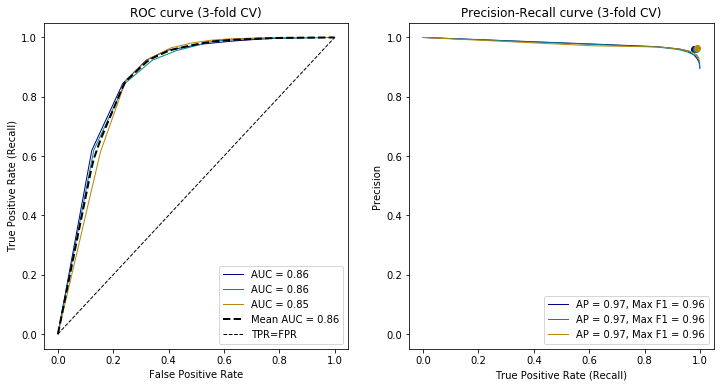

In [7]:
# Synthetic data with highly imbalance classes
from sklearn.datasets import make_classification
minority_class_prevalence = 0.1
class_balance = [minority_class_prevalence, 1.0-minority_class_prevalence]
X, y = make_classification(n_classes=2, 
                           n_features=100, 
                           n_samples=8500,
                           weights=class_balance, 
                           random_state=42)
X_t = StandardScaler().fit_transform(X)
rf_clf = RandomForestClassifier(random_state=2)
rf_clf = plot_binary_ROC(rf_clf, X_t, y, cv_fold=3)

In [8]:
from sklearn.metrics import accuracy_score
y_pred = rf_clf.predict(X_t)
acc_ = accuracy_score(y, y_pred)
_ = confusion_matrix(acc=acc_,
                     population=8500,
                     subpop=0.1)


Inputs
------------
Accuracy (%): 97.55294117647058
Subpopulation (%): 10.0
Population size: 8500
Predicted subpopulation size: 850

Results
------------
True Positives (Power): 829
False Positives (Type I): 208
True Negatives: 7463
False Negatives (Type II): 21

Derivations
------------
True Positive Rate (Recall): 0.9753
False Positive Rate: 0.0271
Precision: 0.7994
Specificity: 0.9729
False Discovery Rate: 0.2006
F-Score: 0.8786


# Interactive ROC Plot with Bokeh

In this next section, we'll do the following:

- Break down our ROC curve plotting algorithm into several functions (e.g. interpolating mean ROC curve). 
- Convert to an interactive plot in Bokeh

Take these steps will allow us to reuse the functions for comparing ROC curves not just for cross-validation but comparing different classifiers or the same classifier with different parameters (very helpful for benchmarking). It will also give you some more familiarity with the API and ideas for how to make your life easier when training and comparing new classifiers.

In [9]:
# First, we'll create a helper function to grab a classifier's name

def get_clf_name(clf):
    """
    get_clf_name takes a classifer (trained or untrained) and returns its name as a string
        clf.__str__() will return a string of the classifiers name and params 
        e.g. "LogisticRegresion(...)" or "(("Logistic Regression(...)"))
        We then split on "(", use filter to drop empty strings, convert to list, and return first item
    clf:    sklearn classifier (e.g. rf = RandomForestClassifier())
    """
    return list(filter(None, clf.__str__().split("(")))[0]

print(get_clf_name(rf_clf))

RandomForestClassifier


In [14]:
from bokeh.plotting import output_notebook, figure, show, ColumnDataSource
from bokeh.models import HoverTool
output_notebook()


def get_ROC_data(data, clf, pos_label_=None, verbose=False):
    
        """
        source_ROC, df_ROC, clf, precision_info = get_ROC_data(data, clf, verbose=False)
        
        get_ROC_data will return ColumnDataSource and dataframes with TPR and FPR
        for a particular dataset and an untrained classifier. The CSD can be used
        to plot a Bokeh plot while the dataframe can be used for additional
        exploration and plotting with other libs. Note that the dataframes
        are returned with metadata (e.g. AUC and the clf used). precision_info is 
        a tuple of (precision, recall, avg_precision) of types (array, array, float).
        
        data:        tuple of our data (X_train, X_test, y_train, y_test)
                         where each item in the tuple is a numpy array
        clf:         an untrained classifier (e.g. rf = RandomForestClassifier())
        pos_label_:  if targets are not binary (0, 1) then indicate integer for "positive" [default: None]
        verbose:     print warnings [default: False]
        """

        # split data into training, testing
        (X_train, X_test, y_train, y_test) = data

        # train and retrieve probabilities of class per feature for the test data
        try:
            probas_ = clf.fit(X_train, y_train).predict_proba(X_test)
        except:
            print("Check if classifer allows for probability calculation.")

        # get false and true positive rates for positive labels
        #    (and thresholds, which is not used but shown here for fyi)
        try:
            fpr, tpr, tresholds_ = roc_curve(y_test, probas_[:, 1], pos_label=pos_label_)
        except:
            pos_label_ = np.max([y_test, y_train])
            fpr, tpr, tresholds_ = roc_curve(y_test, probas_[:, 1], pos_label=pos_label_)
            if verbose:
                print(f"Warning: target data not binary. Maximum target value of '{pos_label_}' used as positive.")
                print("You can use 'pos_label_' to indicate your own.")
                
        # [TODO - WIP] get precision and recall information             
        precision_, recall_, _ = precision_recall_curve(y_test, probas_[:,1], pos_label=pos_label_)
        try:
            avg_precision = average_precision_score(y_test, probas_[:,1])
        except:
            avg_precision = None # TODO: currently doesn't work with non-binary variables
        precision_info = (precision_, recall_, avg_precision)
                                                           
        # get area under the curve (AUC)
        roc_auc = auc(fpr, tpr)
        
        # add origin for nicer plotting
        tpr = np.insert(tpr, 0, 0)
        fpr = np.insert(fpr, 0, 0) 
        
        # create legend variables - we'll create an array with len(tpr)
        auc_ = [f"AUC: {roc_auc:.3f}"]*len(tpr)
        clf_name = get_clf_name(clf)
        clf_ = [f"{clf_name}, AUC: {roc_auc:.3f}"]*len(tpr)
        
        # create bokeh column source for plotting new ROC  
        source_ROC = ColumnDataSource(data=dict(x_fpr=fpr, 
                                                y_tpr=tpr, 
                                                auc_legend=auc_, 
                                                clf_legend=clf_))
        
        # create output dataframe with TPR and FPR, and metadata
        df_ROC = pd.DataFrame({'TPR':tpr, 'FPR':fpr})
        df_ROC.auc = roc_auc
        df_ROC.clf = get_clf_name(clf)
        df_ROC.score = clf.score(X_test, y_test)
        
        return source_ROC, df_ROC, clf, precision_info
    

def interpolate_mean_tpr(FPRs=None, TPRs=None, df_list=None):

    """
    mean_fpr, mean_tpr = interpolate_mean_tpr(FPRs=None, TPRs=None, df_list=None)
    
    FPRs:    False positive rates (list of n arrays)
    TPRs:    True positive rates (list of n arrays)
    df_list: DataFrames with TPR, FPR columns (list of n DataFrames)
    """
    
    mean_tpr, mean_fpr = 0, np.linspace(0, 1, 101)
    
    if TPRs and FPRs:
        for idx, PRs in enumerate(zip(FPRs, TPRs)):
            mean_tpr += np.interp(mean_fpr, PRs[0], PRs[1])
            
    elif df_list:
        for idx, df_ in enumerate(df_list):
            mean_tpr += np.interp(mean_fpr, df_.FPR, df_.TPR)
    
    else:
        print("Please give valid inputs.")
        return None, None

    # normalize by length of inputs (# indices looped over)
    mean_tpr /= (idx+1)
    
    # add origin point
    mean_fpr = np.insert(mean_fpr, 0, 0)
    mean_tpr = np.insert(mean_tpr, 0, 0)
    
    return mean_fpr, mean_tpr
    
    
def plot_ROC_CV(clf, X, y, cv_fold=3, pos_label_=None, verbose=False):
    
    """
    clf, classifiers, df_ROCs = plot_ROC_CV(clf, X, y, cv_fold=3, pos_label_=None, verbose=False)
    
    Plot an interactive ROC curve for a binary classifier with n='cv-fold' cross-validations.
    It returns the original clf, a classifier for each cv, a list of dataframes for each cv,
    and precision_info, which is a tuple of (precision, recall, avg_precision) of types (array, array, float).
    
    clf:          untrained classifier object (e.g. rf_clf = RandomForestClassifer())
    X:            training + testing data
    y:            targets (numeric/integers)
    cv_fold:      cross-validations to run [default: 3]
    pos_label_:   if targets are not binary (0, 1) then indicate integer for "positive" [default: None]
    verbose:      print warnings [default: False]
    """
    
    """ Check cross-validations to run and get stratification """
    # Check cross-validation > 1 and get stratified data
    if cv_fold > 1:
        skf = StratifiedKFold(cv_fold)
    else:
        print(f"cv_fold must be greater than 1. You have input {cv_fold}")
        return clf
    
    """ Get source data for each ROC curve """    
    # Loop over each split in the data and get source data, df, and clf
    source_ROCs, df_ROCs, classifiers = [], [], []
    for idx, val in enumerate(skf.split(X, y)):
        (train, test) = val
        data = (X[train], X[test], y[train], y[test]) # not that skf returns indices, not values
        source_, df_, clf_, precision_info = get_ROC_data(data, clf, pos_label_, verbose)
        source_ROCs.append(source_)
        df_ROCs.append(df_)
        classifiers.append(clf)
        
    """ Set up initial PLOT """
    # Create custom HoverTool -- we'll name each ROC curve 'ROC' so we only see info on hover there
    hover_ = HoverTool(names=['ROC'], tooltips=[("TPR", "@y_tpr"), ("FPR", "@x_fpr")])

    # Create your toolbox
    p_tools = [hover_, 'crosshair', 'zoom_in', 'zoom_out', 'save', 'reset', 'tap', 'box_zoom']

    # Create figure and labels
    clf_name = get_clf_name(clf)
    p = figure(title=f'{clf_name} ROC curve with {cv_fold}-fold cross-validation', tools=p_tools)
    p.xaxis.axis_label = 'False Positive Rate' 
    p.yaxis.axis_label = 'True Positive Rate'
    
    """ Get ROC CURVE for each iteration """
    # Set the matplotlib colorwheel as a cycle
    colors_ = cycle(list(cnames.keys()))
    
    # plot each ROC curve - loop over source_ROCs, colors_
    for _, val in enumerate(zip(source_ROCs, colors_)):
        (ROC, color_) = val 
        p.line('x_fpr', 'y_tpr', line_width=1, color=color_, source=ROC)
        p.circle('x_fpr', 'y_tpr', size=10, color=color_, legend='auc_legend', source=ROC, name='ROC')
    
    """ Mean ROC and AUC for all curves and plot """
    # process inputs
    mean_fpr, mean_tpr = interpolate_mean_tpr(df_list=df_ROCs)
    mean_auc = auc(mean_fpr, mean_tpr)
    mean_legend = [f'Mean, AUC: {mean_auc:.3f}']*len(mean_tpr)
    
    # Create ColumnDataSource
    source_ROC_mean = ColumnDataSource(data=dict(x_fpr=mean_fpr, 
                                                 y_tpr=mean_tpr, 
                                                 auc_legend=mean_legend))
    
    # Plot mean ROC
    p.line('x_fpr', 'y_tpr', legend='auc_legend', color='black', 
           line_width=3.33, line_alpha=0.33, line_dash='dashdot', source=source_ROC_mean, name='ROC')
    
    # Plot chance (tpr = fpr)
    p.line([0, 1], [0, 1], line_dash='dashed', line_width=0.5, color='black', name='Chance')

    # Finishing touches
    p.legend.location = "bottom_right"
    show(p)
                       
    return clf, classifiers, df_ROCs, precision_info


# Interactive ROC Curve with Logistic Regression (iris 1 vs not 1)
rf_clf, rf_cv_clfs, df_rf_ROCs, rf_precision = plot_ROC_CV(rf_clf, X_t, y)

Loading BokehJS ...

## Cool, huh?

I hope this has been useful to you. I want to leave you with a couple more goodies, however. What if I want to look at the ROC of two different classifiers (without CV) to understand their performance? Or what if I have multiple "labels" I want to classify, and I want to know how well my classifier performs at one label versus another?

Well, **with the tools we've built, we should be able to tackle similar plots with ease**.

Let's first take a look at **benchmarking two or more classifiers in a single ROC curve**. 

In [11]:
def plot_ROC_clfs(classifiers, X, y, test_size=0.33, pos_label_=None, verbose=False):
    
    """
    clf, classifiers, df_ROCs, precision_info = plot_ROC_clfs(clf, X, y,pos_label_=None, verbose=False)
    
    Plot an interactive ROC curve for a binary classifier with n='cv-fold' cross-validations.
    It returns the original clf, a classifier for each cv, and a list of dataframes for each cv.
    precision_info is a tuple of (precision, recall, avg_precision) of types (array, array, float).
    
    classifiers:  list of untrained classifiers
    X:            training + testing data
    y:            targets (numeric/integers)
    test_size:    test size for train_test_split (0 < x < 1)
    pos_label_:   if targets are not binary (0, 1) then indicate integer for "positive" [default: None]
    verbose:      print warnings [default: False]
    """
    
    """ Get source data for each ROC curve """
    
    # Get training and test data 
    (data_) = train_test_split(X, y, test_size=test_size)
    
    # Loop over each CLASSIFIER now -- note that we don't redefine our classifiers
    source_ROCs, df_ROCs = [], []
    for _, clf_ in enumerate(classifiers):
        source_, df_, clf_, precision_info = get_ROC_data(data_, clf_, pos_label_, verbose)
        source_ROCs.append(source_)
        df_ROCs.append(df_)
        
    """ Set up initial PLOT """
    
    # Create custom HoverTool -- we'll name each ROC curve 'ROC' so we only see info on hover there
    hover_ = HoverTool(names=['ROC'], tooltips=[("TPR", "@y_tpr"), ("FPR", "@x_fpr")])

    # Create your toolbox
    p_tools = [hover_, 'crosshair', 'zoom_in', 'zoom_out', 'save', 'reset', 'tap', 'box_zoom']

    # Create figure and labels
    p = figure(title=f'Benchmarking {len(classifiers)} classifiers', tools=p_tools)
    p.xaxis.axis_label = 'False Positive Rate' 
    p.yaxis.axis_label = 'True Positive Rate'
    
    """ Get ROC CURVE for each iteration """
    
    # Set the matplotlib colorwheel as a cycle
    colors_ = cycle(list(cnames.keys()))
    
    # loop over source, color and plot each ROC curve
    for _, val in enumerate(zip(source_ROCs, colors_)):
        (ROC, color_) = val 
        p.line('x_fpr', 'y_tpr', line_width=1, color=color_, source=ROC)
        p.circle('x_fpr', 'y_tpr', size=10, color=color_, legend='clf_legend', source=ROC, name='ROC')

    """ Mean ROC and AUC for all curves and plot """
    
    # process mean values, legend, ColumnDataSource
    mean_fpr, mean_tpr = interpolate_mean_tpr(df_list=df_ROCs)
    mean_auc = auc(mean_fpr, mean_tpr)
    mean_legend = [f'Mean, AUC: {mean_auc:.3f}']*len(mean_tpr)
    source_ROC_mean = ColumnDataSource(data=dict(x_fpr = mean_fpr, y_tpr = mean_tpr, roc_legend=mean_legend))

    # PLOT mean ROC
    p.line('x_fpr', 'y_tpr', legend='roc_legend', color='black', 
           line_width=5, line_alpha=0.3, line_dash='dashed', source=source_ROC_mean, name='ROC')
    
    # PLOT chance (tpr = fpr)
    p.line([0, 1], [0, 1], line_dash='dashed', line_width=0.2, color='black', name='Chance')

    # Finishing touches
    p.legend.location = "bottom_right"
    show(p)
    
    # Print scores
    print("Scores:")
    # Get scores for each classifier:
    for i, df_ in enumerate(df_ROCs):
        print(df_.clf, np.round(df_.score, decimals=3))

    return classifiers, df_ROCs, precision_info

# Benchmark Logistic Regression, RF, and KNN (iris 1 vs not 1)
np.random.seed(42)
lr_bench = LogisticRegression(random_state=42)
rf_bench = RandomForestClassifier(random_state=42)
knn_bench = sk.neighbors.KNeighborsClassifier(n_neighbors=3)
clfs_benchmark, dfs_bench, precision_info = plot_ROC_clfs(classifiers=[lr_bench, rf_bench, knn_bench], X=X_t, y=y)

Scores:
LogisticRegression 0.924
RandomForestClassifier 0.934
KNeighborsClassifier 0.897


In [12]:
# Benchmark Logistic Regression, RF, and KNN (iris 1 vs not 1)
np.random.seed(42)
lr_bench = LogisticRegression(random_state=42)
rf_bench = RandomForestClassifier(random_state=42)
knn_bench = sk.neighbors.KNeighborsClassifier(n_neighbors=3)

# Add noisy features to iris then run PCA again
random_state = np.random.RandomState(42)
n_samples, n_features = X_t.shape
X_noisy = np.c_[X_t, random_state.randn(n_samples, 100*n_features)]
outputs = plot_ROC_clfs(classifiers=[lr_bench, rf_bench, knn_bench], X=X_noisy, y=y)

Scores:
LogisticRegression 0.716
RandomForestClassifier 0.925
KNeighborsClassifier 0.884


# Precision-Recall Curve

In [15]:
lr_precision
q = figure()
q.line(lr_precision[1],lr_precision[0]) # recall, vs precision
show(q)

NameError: name 'lr_precision' is not defined